In [78]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader

In [79]:
args = Namespace(
    sequencelength=70,
    dataroot = "/data/sustainbench",
    device="cuda",
    dataset = "ghana"
)

dataroot = args.dataroot

from earlyrnn import EarlyRNN
nclasses = 4
input_dim = 12
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(args.device)
import torch
#model.load_state_dict(torch.load("../snapshots/sustainbenchghanamodel.pth"))
model.load_state_dict(torch.load("../snapshots/sustainbench/ghana.pth"))
model.eval()

EarlyRNN(
  (intransforms): Sequential(
    (0): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=12, out_features=64, bias=True)
  )
  (backbone): LSTM(64, 64, num_layers=2, bias=False, batch_first=True, dropout=0.2)
  (classification_head): ClassificationHead(
    (projection): Sequential(
      (0): Linear(in_features=64, out_features=4, bias=True)
      (1): LogSoftmax(dim=2)
    )
  )
  (stopping_decision_head): DecisionHead(
    (projection): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

In [80]:
train_ds = SustainbenchCrops(root=dataroot,partition="train", sequencelength=args.sequencelength, country=args.dataset)
test_ds = SustainbenchCrops(root=dataroot,partition="test", sequencelength=args.sequencelength, country=args.dataset)

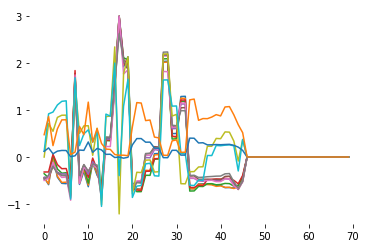

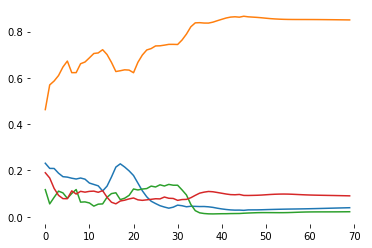

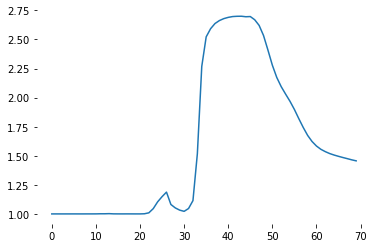

In [81]:
X,y = test_ds[0]
X = X.unsqueeze(0).to(args.device)
log_class_probabilities, probability_stopping = model(X)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X[0].cpu().detach())
plt.figure()
plt.plot(log_class_probabilities[0].cpu().detach().exp())
plt.figure()
plt.plot(probability_stopping[0].cpu().detach().exp())

In [82]:
import numpy as np
from tqdm.notebook import tqdm
dataloader = DataLoader(test_ds, batch_size=16)
device = args.device
model.eval()

stats = []
losses = []
for batch in tqdm(dataloader):
    X, y_true = batch
    X, y_true = X.to(device), y_true.to(device)

    log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
    stat = {}
    stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
    stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
    stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["targets"] = y_true.cpu().detach().numpy()

    stats.append(stat)


# list of dicts to dict of lists
stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}

  0%|          | 0/3704 [00:00<?, ?it/s]

In [87]:
y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]

In [88]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_true, y_pred))

accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.33      0.18      0.23      9844
           1       0.60      0.78      0.68     32694
           2       0.58      0.64      0.61      9882
           3       0.41      0.04      0.07      6836

    accuracy                           0.57     59256
   macro avg       0.48      0.41      0.40     59256
weighted avg       0.53      0.57      0.52     59256



0.5696807074389092

NameError: name 'doy_stop' is not defined

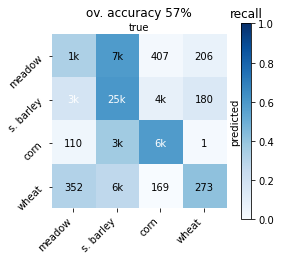

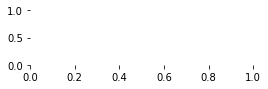

In [86]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn

labels_names = ["meadow", "s. barley", "corn", "wheat", "w. barley", "clover", "triticale"]
acier = "#4F8FCC"
y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]


cm_norm = confusion_matrix(y_pred, y_true, normalize="true")
cm = confusion_matrix(y_pred, y_true)

fig, ax = plt.subplots(1,1, figsize=(4,4))

plt.rc("axes.spines", top=False, right=False, bottom=False, left=False)

ax.set_xticks(range(len(labels_names)))
ax.set_xticklabels(labels_names, rotation=45, ha="right")

ax.set_yticks(range(len(labels_names)))
ax.set_yticklabels(labels_names, rotation=45, ha="right")

im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm_norm[i,j] > 0.5 else "black"
        txt = str(cm[i,j])
        txt = txt[:-3] + "k" if len(txt) > 3 else txt
        ax.text(i,j, txt, ha="center", va="center", color=color)

cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.9, pad = 0.07)
cbar.ax.set_title('recall')

ax.yaxis.set_label_position("right")
ax.set_ylabel("predicted")
ax.xaxis.set_label_position("top")
ax.set_xlabel("true")


accuracy = accuracy_score(y_pred, y_true)
ax.set_title(f"ov. accuracy {accuracy*100:.0f}%")      
fig.savefig("/home/marc/Desktop/elects/ghana_confmat.pdf",dpi=300,bbox_inches='tight')
fig, ax = plt.subplots(1,1, figsize=(4,1))
        
seaborn.histplot(x=doy_stop,ax=ax, color=acier)
seaborn.despine(offset=0, left=True)
ax.set_xlabel("day of year")
ax.set_ylabel("frequency")
ax.set_xlim(0,365)
t = np.linspace(0,360,4)
#ax.set_ylim(-.5,1)
ys = [0.55,0.75,0.55,0.75]
#ax.set_xticks(doys)
ax.set_title(f"stopping doy")
ax.axvline(doy_stop.mean())
ax.text(doy_stop.mean()+5,800, f"avg {doy_stop.mean():.0f} $\pm$ {doy_stop.std():.2f}")
#ax.set_xticklabels(dates, rotation=20, ha='right')
fig.savefig("/home/marc/Desktop/elects/ghana_violin.pdf",dpi=300,bbox_inches='tight')